In [1]:
import json
import datetime
import random
import time
import string
import argparse
import os
import tensorflow as tf
import numpy as np
from tensorflow.models.rnn import rnn_cell
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops

random.seed(0)
np.random.seed(0)

from utils import train_utils
from utils import googlenet_load

import xml
import numpy as np
from pylab import *
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import os
from matplotlib import patches
from random import shuffle

In [2]:
import numpy as np
import random
import json
import os
import cv2
from scipy.misc import imread, imresize

from utils.data_utils import (annotation_jitter, image_to_h5, get_cell_grid)
from utils.train_utils import add_rectangles
from utils.annolist import AnnotationLib as al
from utils.rect import Rect
import copy

In [3]:
# This system might perform poorly if the GoogleNet model was trained on data different than we're feeding.
# In particular, different methods of cropping or resizing, BGR vs RGB, different whitening, etc could have 
# very large effects on how well this system works. 

In [4]:
H = {
    "data": {
        "train_idl": "./data/pascal/pascal_voc_train.idl",
        "test_idl": "./data/pascal/pascal_voc_train.idl",
        "truncate_data": False   # Only loads first 10 files
    },
    "arch": {
        "use_lstm": False,
        "use_dropout": True, 
        "image_width": 640, 
        "image_height": 480,
        "grid_height": 15, 
        "grid_width": 20,
        "batch_size": 2, 
        "region_size": 32,
        "lstm_size": 200,
        "num_classes": 21,
        "rnn_len": 1
    }, 
    "logging": {
    },
    "solver": {
        "opt": "RMS",
        "use_jitter": False,
        "rnd_seed": 1,
        "epsilon": 0.00001, 
        "learning_rate": 0.001, 
        "learning_rate_step": 7500, 
        "weights": "",
        "head_weights": [1.0, 0.1]   # The relative weighting of loss for bounding boxes and class predictions (not sure order)
    }
}
H['solver']['gpu'] = 0
H['exp_name'] = "pascal"
H['save_dir'] = "/home/ubuntu/external_drive/tensorbox_outputs" + '/%s_%s' % (H['exp_name'],
        datetime.datetime.now().strftime('%Y_%m_%d_%H.%M'))
H['arch']['num_classes'] = 2

In [5]:
# Makes a Rect object from my box class. Used to get the cool Rect methods. Confidence set to -1.
def box_to_rect(box):
    return Rect(box.xmin, box.ymin, box.xmax - box.xmin, box.ymax - box.ymin, confidence = -1)

def box_to_anno_rect(box):
    return al.AnnoRect(box.xmin, box.ymin, box.xmax, box.ymax)

def annotation_to_h5(a, cell_width, cell_height, max_len):
    region_size = 32
    # Makes a cell_width x cell_height grid of region_size x region_size rects
    cell_regions = get_cell_grid(cell_width, cell_height, region_size)

    cells_per_image = len(cell_regions)
    
    # Makes a blank list of boxes 
    box_list = [[] for idx in range(cells_per_image)]
            
    for cidx, c in enumerate(cell_regions):
        # put in box_list[cell_index] the list of all annotations that intersect somehow ??? with this box
        box_list[cidx] = [box_to_anno_rect(r) for r in a[1] if all(box_to_anno_rect(r).intersection(c))]
    
    # a list of cells in the image
    # [0, cell_id, :, box_id, 0] returns the box coords and size
    boxes = np.zeros((1, cells_per_image, 4, max_len, 1), dtype = np.float)
    
    # a flag to indicate if there's an item in the box
    box_flags = np.zeros((1, cells_per_image, 1, max_len, 1), dtype = np.float)
    
    # Iterate through each cell
    for cidx in range(cells_per_image):
        
        # Get the number of classes in this cell. Since max_len is default 1, ...
        cur_num_boxes = min(len(box_list[cidx]), max_len)
        #assert(cur_num_boxes <= max_len)
        
        # Indicate that the first cur_num_boxes rows of the array have an associated box 
        box_flags[0, cidx, 0, 0:cur_num_boxes, 0] = 1
        
        # Get the coords of the center of the cell
        cell_ox = 0.5*(cell_regions[cidx].x1 + cell_regions[cidx].x2)
        cell_oy = 0.5*(cell_regions[cidx].y1 + cell_regions[cidx].y2)
        
        # create a list of the relative positions of annotation boxes within each cell
        unsorted_boxes = []
        for bidx in range(cur_num_boxes):

            # relative box position with respect to cell
            ox = 0.5 * (box_list[cidx][bidx].x1 + box_list[cidx][bidx].x2) - cell_ox
            oy = 0.5 * (box_list[cidx][bidx].y1 + box_list[cidx][bidx].y2) - cell_oy

            width = abs(box_list[cidx][bidx].x2 - box_list[cidx][bidx].x1)
            height= abs(box_list[cidx][bidx].y2 - box_list[cidx][bidx].y1)

            unsorted_boxes.append(np.array([ox, oy, width, height], dtype=np.float))
        
        # Sort boxes by distance from center of cell
        for bidx, box in enumerate(sorted(unsorted_boxes, key=lambda x: x[0]**2 + x[1]**2)):
            boxes[0, cidx, :, bidx, 0] = box
    
    # Returns data containing the relative positions of the annotation boxes within each cell in a grid
    # and a flag indicating which cells actually have annotations within them
    # boxes[0, cell_id, :, box_id, 0] returns the box coords and size
    # box_flags[0, cell_id, 0, box_id, 0] returns whether or not there is actually a box at the given indices
    return boxes, box_flags

# Rescales an image and its bounding boxes to the target dimensions
def rescale_boxes(I, anno, target_height, target_width):
    x_scale = target_width / float(I.shape[1])
    y_scale = target_height / float(I.shape[0])
    this_anno = copy.deepcopy(anno)
    for r in this_anno[1]:
        #r = box_to_rect(r)
        assert r.xmin < r.xmax
        r.xmin *= x_scale
        r.xmax *= x_scale
        assert r.ymin < r.ymax
        r.ymin *= y_scale
        r.ymax *= y_scale
    I_r = imresize(I, (target_height, target_width), interp='cubic')
    return I_r, this_anno

def load_idl_tf(H, jitter):
    """Take the idlfile and net configuration and create a generator
    that outputs a jittered version of a random image from the annolist
    that is mean corrected."""

    # Pull annotations from the global "annotations"
    # annotations is a list of (filename, bounding_boxes)'s
    annos = annotations
    random.seed(0)
    # Only use first 10 if truncate_data flag is set
    #if H['data']['truncate_data']:
    #    annos = annos[:10]
    while True:
        random.shuffle(annos)
        for anno in annos:
            # Load in the image contained in the filename
            I = imread(anno[0])
            if I.shape[0] != H["arch"]["image_height"] or I.shape[1] != H["arch"]["image_width"]:
                I, anno = rescale_boxes(I, anno, H["arch"]["image_height"], H["arch"]["image_width"])
            """
            if jitter:
                jitter_scale_min=0.9
                jitter_scale_max=1.1
                jitter_offset=16
                I, anno = annotation_jitter(I,
                                            anno, target_width=H["arch"]["image_width"],
                                            target_height=H["arch"]["image_height"],
                                            jitter_scale_min=jitter_scale_min,
                                            jitter_scale_max=jitter_scale_max,
                                            jitter_offset=jitter_offset)
            """
            # Idk what this shit is, and it'll definitely break..
            boxes, flags = annotation_to_h5(anno,
                                            H["arch"]["grid_width"],
                                            H["arch"]["grid_height"],
                                            H["arch"]["rnn_len"])

            yield {"image": I, "boxes": boxes, "flags": flags}

In [6]:

def do_input_test(generator):
    
    data = next(generator)
    image = data["image"]
    flags = data["flags"]
    boxes = data["boxes"]
    #plt.imshow(image)
    image = image.reshape([1, 480, 640, 3])
    boxes = boxes.reshape([300, 4])
    flags = flags.reshape([300, 1])
    confs = np.array([[make_sparse(detection, d=2) for detection in cell] for cell in flags])
    confs = confs.reshape([300, 2])
    # This probably overlays the rectange on the image???
    test_output_to_log = train_utils.add_rectangles(image,
                                                    confs,
                                                    boxes,
                                                    H["arch"])[0]
    #print(boxes)
    plt.figure()
    plt.imshow(test_output_to_log)

In [7]:
#my_gen = load_idl_tf(H, False)
#my_gen2 = load_idl_tf(H, False)

In [8]:

#for x in range(5):
#    do_input_test(my_gen)
#for x in range(5):
#    do_input_test(my_gen2)

In [9]:
# Creates a 1-hot encoding of n given total num classes d
def make_sparse(n, d):
    v = np.zeros((d,), dtype=np.float32)
    v[n] = 1.
    return v

def load_data_gen(H, phase, jitter):
    grid_size = H["arch"]['grid_width'] * H["arch"]['grid_height']

    data = load_idl_tf(H, jitter={'train': jitter, 'test': False}[phase])

    for d in data:
        output = {}
        
        rnn_len = H["arch"]["rnn_len"]
        flags = d['flags'][0,:,0,0:rnn_len,0]
        boxes = np.transpose(d['boxes'][0,:,:,0:rnn_len,0], (0,2,1))
        assert(flags.shape == (grid_size, rnn_len))
        assert(boxes.shape == (grid_size, rnn_len, 4))

        output['image'] = d['image']
        output['confs'] = np.array([[make_sparse(detection, d=2) for detection in cell] for cell in flags])
        output['boxes'] = boxes
        output['flags'] = flags
        
        yield output


In [10]:
"""
How this network works:

Architecture:
    Standard conv-net. Final convolutional layer is connected to two fully-connected layers (in parallel, not series).
    Confidences layer outputs a [num_classes] vector with predicted class confdiences for each position in the localization grid.
    Bounding-box regressor layer outputs a regressed bounding box for each position in the grid.

Training:
    For a given training image, the localization grid is generated. For each position in the grid, a sparse vector 
    (like one-hot, but with a few places that can be "hot") is created that defines if a certain class is in that box in the image.
    Also, for each occurance of a class, a "regression target" is created of where the object actually is within the grid box.

"""

'\nHow this network works:\n\nArchitecture:\n    Standard conv-net. Final convolutional layer is connected to two fully-connected layers (in parallel, not series).\n    Confidences layer outputs a [num_classes] vector with predicted class confdiences for each position in the localization grid.\n    Bounding-box regressor layer outputs a regressed bounding box for each position in the grid.\n\nTraining:\n    For a given training image, the localization grid is generated. For each position in the grid, a sparse vector \n    (like one-hot, but with a few places that can be "hot") is created that defines if a certain class is in that box in the image.\n    Also, for each occurance of a class, a "regression target" is created of where the object actually is within the grid box.\n\n'

In [11]:
@ops.RegisterGradient("Hungarian")
def _hungarian_grad(op, *args):
    return map(array_ops.zeros_like, op.inputs)

In [12]:
def build_overfeat_forward(H, x, googlenet, phase):
    """
    Inputs:
        H: hyperparameters
        x: inputs in some form???
        googlenet: an initialized googlenet instance
        phase: {train, test}
    Returns:
        pred_boxes: the op that predicts bounding boxes
        pred_logits: the linear op that predicts classes
        pred_confidences: the softmax class classifier op. Size [num_locations * batch_size, num_classes]
    """
    # Subtract image mean from image
    input_mean = 117.
    x -= input_mean
    
    # Grab the last convolutional layer from a new GoogleNet graph
    Z = googlenet_load.model(x, googlenet, H)
    
    grid_size = H['arch']['grid_width'] * H['arch']['grid_height']
    
    # If necessary, add a dropout layer to the graph
    if H['arch']['use_dropout'] and phase == 'train':
        Z = tf.nn.dropout(Z, 0.5)
    
    # Currently, W[0] is [1024, num_classes], and B is [num_classes]
    # Z is [batch_size * grid_width * grid_height, 1024]
    pred_logits = tf.matmul(Z, googlenet['W'][0]) + googlenet['B'][0] #, name=phase+'/logits_0')
    # Reshape to [batch_size * grid_width * grid_height, num_classes]
    # I think it's already this shape???
    pred_logits = tf.reshape(pred_logits, [H['arch']['batch_size'] * grid_size, H['arch']['num_classes']])
    # Do a softmax on this
    # Result is, for each location, the confidence of each class
    pred_confidences = tf.nn.softmax(pred_logits)
    
    # Now, do the same thing for the boxes
    # WHAT THE HELL IS THE * 100 at the end???
    # also, these reshapes make no sense - it's just un-reshaped in build_overfeat...
    pred_boxes = tf.reshape(tf.nn.xw_plus_b(Z, googlenet['W'][1], googlenet['B'][1],
                                            name=phase+'/logits_1'), 
                            [H['arch']['batch_size'] * grid_size, 1, 4]) * 100
    return pred_boxes, pred_logits, pred_confidences


def build_overfeat(H, x, googlenet, phase, boxes, confidences_r):
    # Build the forward part
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, x, googlenet, phase)

    grid_size = H['arch']['grid_width'] * H['arch']['grid_height']
    
    # Reshape boxes to [num_locations * batch_size, 4]
    boxes = tf.cast(tf.reshape(boxes, [H['arch']['batch_size'] * grid_size, 4]), 'float32')
    
    # Calculate cross-entropy between real classes and predictions at each grid position
    cross_entropy = -tf.reduce_sum(confidences_r*tf.log(tf.nn.softmax(pred_logits) + 1e-6))
    
    # Loss function based on difference between predicted boxes and actual boxes for boxes with an object
    box_regressor_loss = tf.abs(pred_boxes[:, 0, :] - boxes) * tf.expand_dims(confidences_r[:, 1], 1)
    
    # Apply weights to losses 
    L = (H['solver']['head_weights'][0] * cross_entropy,
         H['solver']['head_weights'][1] * box_regressor_loss)
    
    # Sum up weighted losses for confidences and normalize to batch and grid size
    confidences_loss = (tf.reduce_sum(L[0], name=phase+'/confidences_loss') /
                        (H['arch']['batch_size'] * grid_size))
    
    # Sum up weighted losses for boxes and normalize to batch and grid size
    boxes_loss = (tf.reduce_sum(L[1], name=phase+'/boxes_loss') /
                  (H['arch']['batch_size'] * grid_size))
    
    # Total loss
    loss = confidences_loss + boxes_loss
    
    return pred_boxes, pred_confidences, loss, confidences_loss, boxes_loss

def build(H, q):
    '''
    Build full model for training, including forward / backward passes,
    optimizers, and summary statistics.
    Inputs:
        H: hyperparameter dict
        q: dict with queues for train and test input examples
    '''
    arch = H['arch']
    solver = H["solver"]

    os.environ['CUDA_VISIBLE_DEVICES'] = str(solver['gpu'])

    #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    gpu_options = tf.GPUOptions()
    config = tf.ConfigProto(gpu_options=gpu_options)
    
    # Run googlenet_load init function
    googlenet = googlenet_load.init(H, config)
    
    # Configure solver
    learning_rate = tf.placeholder(tf.float32)
    if solver['opt'] == 'RMS':
        opt = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                        decay=0.9, epsilon=solver['epsilon'])
    elif solver['opt'] == 'SGD':
        opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    else:
        raise ValueError('Unrecognized opt (optimizer) type')
    
    # We build two separate networks for training and testing!!! (is this necessary???)
    loss, accuracy, confidences_loss, boxes_loss = {}, {}, {}, {}
    for phase in ['train', 'test']:
        # Get inputs from queue
        x, confidences, boxes = q[phase].dequeue_many(arch['batch_size'])
        
        # ???
        flags = tf.argmax(confidences, 3)


        grid_size = H['arch']['grid_width'] * H['arch']['grid_height']
        confidences_r = tf.cast(
            tf.reshape(confidences[:, :, 0, :],
                       [H['arch']['batch_size'] * grid_size, arch['num_classes']]), 'float32')
        
        (pred_boxes, pred_confidences,
         loss[phase], confidences_loss[phase],
         boxes_loss[phase]) = build_overfeat(H, x, googlenet, phase, boxes, confidences_r)


        # Set up summary operations for tensorboard
        a = tf.equal(tf.argmax(confidences_r, 1), tf.argmax(pred_confidences, 1))
        accuracy[phase] = tf.reduce_mean(tf.cast(a, 'float32'), name=phase+'/accuracy')

        if phase == 'train':
            global_step = tf.Variable(0, trainable=False)
            train_op = opt.minimize(loss['train'], global_step=global_step)
        elif phase == 'test':
            test_image = x
            moving_avg = tf.train.ExponentialMovingAverage(0.99)
            smooth_op = moving_avg.apply([accuracy['train'], accuracy['test'],
                                          confidences_loss['train'], boxes_loss['train'],
                                          confidences_loss['test'], boxes_loss['test'],
                                          ])

            for p in ['train', 'test']:
                tf.scalar_summary('%s/accuracy' % p, accuracy[p])
                tf.scalar_summary('%s/accuracy/smooth' % p, moving_avg.average(accuracy[p]))
                tf.scalar_summary("%s/confidences_loss" % p, confidences_loss[p])
                tf.scalar_summary("%s/confidences_loss/smooth" % p,
                    moving_avg.average(confidences_loss[p]))
                tf.scalar_summary("%s/regression_loss" % p, boxes_loss[p])
                tf.scalar_summary("%s/regression_loss/smooth" % p,
                    moving_avg.average(boxes_loss[p]))

            # show ground truth to verify labels are correct
            test_true_confidences = confidences_r
            test_true_boxes = boxes[0, :, 0, :]

            # show predictions to visualize training progress
            test_pred_confidences = pred_confidences
            test_pred_boxes = pred_boxes[:, 0, :]

    summary_op = tf.merge_all_summaries()

    return (config, loss, accuracy, summary_op, train_op, googlenet['W_norm'],
            test_image, test_pred_boxes, test_pred_confidences,
            test_true_boxes, test_true_confidences, smooth_op,
            global_step, learning_rate)

In [13]:
# PASCAL VOC Data import
home_dir = os.path.expanduser('~') + "/"
datasets_dir = home_dir + "external_drive/"
voc_2012_dir = datasets_dir + "VOC/VOC2012/VOCdevkit/VOC2012/"

classes_to_index = {"aeroplane":1, "bicycle":2, "boat":3, "bottle":4, "bus":5, "car":6, "cat":7,
"chair":8, "cow":9, "diningtable":10, "dog":11, "horse":12, "motorbike":13, "person":14,
"pottedplant":15, "sheep":16, "train":17, "tvmonitor":18, "sofa":19, "bird":20}

indexes_to_classes = [0]*21
for key, value in classes_to_index.items():
    indexes_to_classes[value] = key

class bounding_box:
    def __init__(self, class_name, xmin, xmax, ymin, ymax):
        self.class_name = class_name
        #self.bbox_coords = bbox_coords #xmax, xmin, ymax, ymin
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

# Get list of training images
train_filenames = []
with open(voc_2012_dir + "ImageSets/Main/train.txt", "r") as file:
    for line in file:
        train_filenames.append(line.strip())
        
# Read an annotation file, return a list of bounding boxes
def get_bounding_boxes(filename):
    bounding_boxes = []
    xmldoc = ET.parse(voc_2012_dir + "Annotations/{}.xml".format(filename))
    objects = xmldoc.findall('object')
    for thing in objects:
        name = thing.find('name').text
        box = thing.find('bndbox')
        xmax = int(box.find('xmax').text)
        xmin = int(box.find('xmin').text)
        ymax = int(box.find('ymax').text)
        ymin = int(box.find('ymin').text)
        bounding_boxes.append(bounding_box(name, xmin, xmax, ymin, ymax))
    return bounding_boxes

# Make a list of annotations in the format (filename, bounding_boxes)
annotations = []
for filename in train_filenames:
    full_filename = voc_2012_dir + "JPEGImages/{}.jpg".format(filename)
    bounding_boxes = get_bounding_boxes(filename)
    annotations.append((full_filename, bounding_boxes))

In [14]:
do_saves = True

In [15]:
if do_saves:
    # Make sure directory for saving model checkpoints and data exists
    if not os.path.exists(H['save_dir']): 
        os.makedirs(H['save_dir'])

    # Dump hyperparameters to file for reference
    ckpt_file = H['save_dir'] + '/save.ckpt'
    with open(H['save_dir'] + '/hypes.json', 'w') as f:
        json.dump(H, f, indent=4)

# Set up placeholder ops for inputs
x_in = tf.placeholder(tf.float32)
confs_in = tf.placeholder(tf.float32)
boxes_in = tf.placeholder(tf.float32)

# Queue to hold train and test inputs - (x_in, confs_in, boxes_in)
q = {}
# Enqueue op for train or test queues
enqueue_op = {}
for phase in ['train', 'test']:
    # Each queue holds 3 tensors - each of type tf.float32
    dtypes = [tf.float32, tf.float32, tf.float32]
    # Set up a (default 15x20 grid) to do ???
    grid_size = H['arch']['grid_width'] * H['arch']['grid_height']
    shapes = (
        [H['arch']['image_height'], H['arch']['image_width'], 3], # Size of input image
        [grid_size, H['arch']['rnn_len'], H['arch']['num_classes']], # ???
        [grid_size, H['arch']['rnn_len'], 4], # ???
        )
    q[phase] = tf.FIFOQueue(capacity=30, dtypes=dtypes, shapes=shapes)
    enqueue_op[phase] = q[phase].enqueue((x_in, confs_in, boxes_in))

# Make a dictionary to feed into the training step of tensorflow
def make_feed(d):
    return {x_in: d['image'], confs_in: d['confs'], boxes_in: d['boxes'],
            learning_rate: H['solver']['learning_rate']}

# A loop that enqueues data - to be run in its own thread
# Phase is {train, test}
# gen is a generator for examples to enqueue
def MyLoop(sess, enqueue_op, phase, gen):
    for d in gen:
        sess.run(enqueue_op[phase], feed_dict=make_feed(d))

# Build the network! Returns a bunch of useful ops
(config, loss, accuracy, summary_op, train_op, W_norm,
 test_image, test_pred_boxes, test_pred_confidences,
 test_true_boxes, test_true_confidences,
 smooth_op, global_step, learning_rate) = build(H, q)


# Create ops to log an input image, if given to fill placeholder test_image_to_log
test_image_to_log = tf.placeholder(tf.uint8,
                                   [H['arch']['image_height'], H['arch']['image_width'], 3])
log_image_name = tf.placeholder(tf.string)
log_image = tf.image_summary(log_image_name, tf.expand_dims(test_image_to_log, 0))

In [16]:
#derp

In [17]:
sess = tf.InteractiveSession()

In [18]:
# Set up a saver
saver = tf.train.Saver(max_to_keep=None)
writer = tf.train.SummaryWriter(
    logdir=H['save_dir'], 
    graph_def=sess.graph_def,
    flush_secs=10
)

In [19]:
#next(gen)

In [20]:
# Start threads to keep queues filled with input examples
threads = []
for phase in ['train', 'test']:
    # enqueue once manually to avoid thread start delay
    gen = load_data_gen(H, phase, jitter=H['solver']['use_jitter'])
    d = next(gen)
    sess.run(enqueue_op[phase], feed_dict=make_feed(d))
    
    # Create a thread to enqueue data
    threads.append(tf.train.threading.Thread(target=MyLoop,
                                             args=(sess, enqueue_op, phase, gen)))
    threads[-1].start()

# Set tensorflow random seed from hyperparameter config
tf.set_random_seed(H['solver']['rnd_seed'])

# Initialize variables
sess.run(tf.initialize_all_variables())

# If a file to restore from is specified, restore from checkpoint
#weights_str = H['solver']['weights']
#if len(weights_str) > 0:
#    print('Restoring from: %s' % weights_str)
#    saver.restore(sess, weights_str)

/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [21]:
path_to_checkpoint = "/home/ubuntu/packages/tensorbox/pascal_2016_03_13_06.40/save.ckpt-17000"
saver.restore(sess, path_to_checkpoint)

/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
# train model for N iterations
start = time.time()

for i in range(34000, 1000000):
    # Evaluate the network every display_iter iterations
    display_iter = 10
    
    # Learning rate decay function
    adjusted_lr = (H['solver']['learning_rate'] *
                   0.5 ** max(0, (i / H['solver']['learning_rate_step']) - 2))
    lr_feed = {learning_rate: adjusted_lr}
    
    if i % display_iter == 0:
        if i > 0:
            # Print timings
            dt = (time.time() - start) / (H['arch']['batch_size'] * display_iter)
        
        # Reset timer
        start = time.time()
        
        # Run network and get lots of things back
        (batch_loss_train, test_accuracy, weights_norm, 
            summary_str, np_test_image, np_test_pred_boxes,
            np_test_pred_confidences, np_test_true_boxes,
            np_test_true_confidences, _, _) = sess.run([
                 loss['train'], accuracy['test'], W_norm, 
                 summary_op, test_image, test_pred_boxes,
                 test_pred_confidences, test_true_boxes, test_true_confidences,
                 train_op, smooth_op,
                ], feed_dict=lr_feed)
        
        
        pred_true = [("%d_pred_output" % (i % 3), np_test_pred_boxes, np_test_pred_confidences),
                     ("%d_true_output" % (i % 3), np_test_true_boxes, np_test_true_confidences)]
        
        # For each box in the image (both real and predicted), create a summary image
        # with the box overlaid on it
        for name, boxes, confidences in pred_true:
            # This probably overlays the rectange on the image???
            test_output_to_log = train_utils.add_rectangles(np_test_image,
                                                            confidences,
                                                            boxes,
                                                            H["arch"])[0]
            
            # Check that test_output_to_log is indeed an image
            assert test_output_to_log.shape == (H['arch']['image_height'],
                                                H['arch']['image_width'], 3)
            
            # Feed the image into its placeholder
            feed = {test_image_to_log: test_output_to_log, log_image_name: name}
            
            # Get and add the image summary
            test_image_summary_str = sess.run(log_image, feed_dict=feed)
            if do_saves: writer.add_summary(test_image_summary_str, global_step=global_step.eval())
        
        # Add the real summary
        if do_saves: writer.add_summary(summary_str, global_step=global_step.eval())
        
        # Print progress update
        print_str = ', '.join([
            'Step: %d',
            'lr: %f',
            'Train Loss: %.2f',
            'Test Accuracy: %.1f%%',
            'Time/image (ms): %.1f'
        ])
        print(print_str % 
              (i, adjusted_lr, batch_loss_train,
               test_accuracy * 100, dt * 1000 if i > 0 else 0))
    else:
        # Run the training step
        batch_loss_train, _ = sess.run([loss['train'], train_op], feed_dict=lr_feed)
    
    # Every 1000 steps, save a checkpoint
    if global_step.eval() % 1000 == 0: 
        if do_saves: saver.save(sess, ckpt_file, global_step=global_step)

Step: 34000, lr: 0.000173, Train Loss: 14.14, Test Accuracy: 65.5%, Time/image (ms): 0.0
Step: 34010, lr: 0.000173, Train Loss: 20.20, Test Accuracy: 70.8%, Time/image (ms): 488.1
Step: 34020, lr: 0.000172, Train Loss: 15.08, Test Accuracy: 62.7%, Time/image (ms): 437.3
Step: 34030, lr: 0.000172, Train Loss: 16.48, Test Accuracy: 70.0%, Time/image (ms): 431.7
Step: 34040, lr: 0.000172, Train Loss: 25.07, Test Accuracy: 68.2%, Time/image (ms): 437.3
Step: 34050, lr: 0.000172, Train Loss: 19.12, Test Accuracy: 52.0%, Time/image (ms): 437.8
Step: 34060, lr: 0.000172, Train Loss: 18.79, Test Accuracy: 74.0%, Time/image (ms): 435.8
Step: 34070, lr: 0.000172, Train Loss: 12.81, Test Accuracy: 54.3%, Time/image (ms): 434.8
Step: 34080, lr: 0.000171, Train Loss: 16.56, Test Accuracy: 71.7%, Time/image (ms): 441.8
Step: 34090, lr: 0.000171, Train Loss: 21.89, Test Accuracy: 67.3%, Time/image (ms): 435.6
Step: 34100, lr: 0.000171, Train Loss: 28.49, Test Accuracy: 62.8%, Time/image (ms): 434.7
S

/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


InternalError: Error writing (tmp) checkpoint file: ./pascal_2016_03_13_23.30/save.ckpt-45000.tempstate13189610182041311452: Resource exhausted: ./pascal_2016_03_13_23.30/save.ckpt-45000.tempstate13189610182041311452
	 [[Node: save/save = SaveSlices[T=[DT_INT32, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/save/tensor_names, save/save/shapes_and_slices, Variable, conv2d0_b/_5651, conv2d0_b/RMSProp/_5653, conv2d0_b/RMSProp_1/_5655, conv2d0_w/_5657, conv2d0_w/RMSProp/_5659, conv2d0_w/RMSProp_1/_5661, conv2d1_b/_5663, conv2d1_b/RMSProp/_5665, conv2d1_b/RMSProp_1/_5667, conv2d1_w/_5669, conv2d1_w/RMSProp/_5671, conv2d1_w/RMSProp_1/_5673, conv2d2_b/_5675, conv2d2_b/RMSProp/_5677, conv2d2_b/RMSProp_1/_5679, conv2d2_w/_5681, conv2d2_w/RMSProp/_5683, conv2d2_w/RMSProp_1/_5685, head0_bottleneck_b/_5687, head0_bottleneck_w/_5689, head1_bottleneck_b/_5691, head1_bottleneck_w/_5693, mixed3a_1x1_b/_5695, mixed3a_1x1_b/RMSProp/_5697, mixed3a_1x1_b/RMSProp_1/_5699, mixed3a_1x1_w/_5701, mixed3a_1x1_w/RMSProp/_5703, mixed3a_1x1_w/RMSProp_1/_5705, mixed3a_3x3_b/_5707, mixed3a_3x3_b/RMSProp/_5709, mixed3a_3x3_b/RMSProp_1/_5711, mixed3a_3x3_bottleneck_b/_5713, mixed3a_3x3_bottleneck_b/RMSProp/_5715, mixed3a_3x3_bottleneck_b/RMSProp_1/_5717, mixed3a_3x3_bottleneck_w/_5719, mixed3a_3x3_bottleneck_w/RMSProp/_5721, mixed3a_3x3_bottleneck_w/RMSProp_1/_5723, mixed3a_3x3_w/_5725, mixed3a_3x3_w/RMSProp/_5727, mixed3a_3x3_w/RMSProp_1/_5729, mixed3a_5x5_b/_5731, mixed3a_5x5_b/RMSProp/_5733, mixed3a_5x5_b/RMSProp_1/_5735, mixed3a_5x5_bottleneck_b/_5737, mixed3a_5x5_bottleneck_b/RMSProp/_5739, mixed3a_5x5_bottleneck_b/RMSProp_1/_5741, mixed3a_5x5_bottleneck_w/_5743, mixed3a_5x5_bottleneck_w/RMSProp/_5745, mixed3a_5x5_bottleneck_w/RMSProp_1/_5747, mixed3a_5x5_w/_5749, mixed3a_5x5_w/RMSProp/_5751, mixed3a_5x5_w/RMSProp_1/_5753, mixed3a_pool_reduce_b/_5755, mixed3a_pool_reduce_b/RMSProp/_5757, mixed3a_pool_reduce_b/RMSProp_1/_5759, mixed3a_pool_reduce_w/_5761, mixed3a_pool_reduce_w/RMSProp/_5763, mixed3a_pool_reduce_w/RMSProp_1/_5765, mixed3b_1x1_b/_5767, mixed3b_1x1_b/RMSProp/_5769, mixed3b_1x1_b/RMSProp_1/_5771, mixed3b_1x1_w/_5773, mixed3b_1x1_w/RMSProp/_5775, mixed3b_1x1_w/RMSProp_1/_5777, mixed3b_3x3_b/_5779, mixed3b_3x3_b/RMSProp/_5781, mixed3b_3x3_b/RMSProp_1/_5783, mixed3b_3x3_bottleneck_b/_5785, mixed3b_3x3_bottleneck_b/RMSProp/_5787, mixed3b_3x3_bottleneck_b/RMSProp_1/_5789, mixed3b_3x3_bottleneck_w/_5791, mixed3b_3x3_bottleneck_w/RMSProp/_5793, mixed3b_3x3_bottleneck_w/RMSProp_1/_5795, mixed3b_3x3_w/_5797, mixed3b_3x3_w/RMSProp/_5799, mixed3b_3x3_w/RMSProp_1/_5801, mixed3b_5x5_b/_5803, mixed3b_5x5_b/RMSProp/_5805, mixed3b_5x5_b/RMSProp_1/_5807, mixed3b_5x5_bottleneck_b/_5809, mixed3b_5x5_bottleneck_b/RMSProp/_5811, mixed3b_5x5_bottleneck_b/RMSProp_1/_5813, mixed3b_5x5_bottleneck_w/_5815, mixed3b_5x5_bottleneck_w/RMSProp/_5817, mixed3b_5x5_bottleneck_w/RMSProp_1/_5819, mixed3b_5x5_w/_5821, mixed3b_5x5_w/RMSProp/_5823, mixed3b_5x5_w/RMSProp_1/_5825, mixed3b_pool_reduce_b/_5827, mixed3b_pool_reduce_b/RMSProp/_5829, mixed3b_pool_reduce_b/RMSProp_1/_5831, mixed3b_pool_reduce_w/_5833, mixed3b_pool_reduce_w/RMSProp/_5835, mixed3b_pool_reduce_w/RMSProp_1/_5837, mixed4a_1x1_b/_5839, mixed4a_1x1_b/RMSProp/_5841, mixed4a_1x1_b/RMSProp_1/_5843, mixed4a_1x1_w/_5845, mixed4a_1x1_w/RMSProp/_5847, mixed4a_1x1_w/RMSProp_1/_5849, mixed4a_3x3_b/_5851, mixed4a_3x3_b/RMSProp/_5853, mixed4a_3x3_b/RMSProp_1/_5855, mixed4a_3x3_bottleneck_b/_5857, mixed4a_3x3_bottleneck_b/RMSProp/_5859, mixed4a_3x3_bottleneck_b/RMSProp_1/_5861, mixed4a_3x3_bottleneck_w/_5863, mixed4a_3x3_bottleneck_w/RMSProp/_5865, mixed4a_3x3_bottleneck_w/RMSProp_1/_5867, mixed4a_3x3_w/_5869, mixed4a_3x3_w/RMSProp/_5871, mixed4a_3x3_w/RMSProp_1/_5873, mixed4a_5x5_b/_5875, mixed4a_5x5_b/RMSProp/_5877, mixed4a_5x5_b/RMSProp_1/_5879, mixed4a_5x5_bottleneck_b/_5881, mixed4a_5x5_bottleneck_b/RMSProp/_5883, mixed4a_5x5_bottleneck_b/RMSProp_1/_5885, mixed4a_5x5_bottleneck_w/_5887, mixed4a_5x5_bottleneck_w/RMSProp/_5889, mixed4a_5x5_bottleneck_w/RMSProp_1/_5891, mixed4a_5x5_w/_5893, mixed4a_5x5_w/RMSProp/_5895, mixed4a_5x5_w/RMSProp_1/_5897, mixed4a_pool_reduce_b/_5899, mixed4a_pool_reduce_b/RMSProp/_5901, mixed4a_pool_reduce_b/RMSProp_1/_5903, mixed4a_pool_reduce_w/_5905, mixed4a_pool_reduce_w/RMSProp/_5907, mixed4a_pool_reduce_w/RMSProp_1/_5909, mixed4b_1x1_b/_5911, mixed4b_1x1_b/RMSProp/_5913, mixed4b_1x1_b/RMSProp_1/_5915, mixed4b_1x1_w/_5917, mixed4b_1x1_w/RMSProp/_5919, mixed4b_1x1_w/RMSProp_1/_5921, mixed4b_3x3_b/_5923, mixed4b_3x3_b/RMSProp/_5925, mixed4b_3x3_b/RMSProp_1/_5927, mixed4b_3x3_bottleneck_b/_5929, mixed4b_3x3_bottleneck_b/RMSProp/_5931, mixed4b_3x3_bottleneck_b/RMSProp_1/_5933, mixed4b_3x3_bottleneck_w/_5935, mixed4b_3x3_bottleneck_w/RMSProp/_5937, mixed4b_3x3_bottleneck_w/RMSProp_1/_5939, mixed4b_3x3_w/_5941, mixed4b_3x3_w/RMSProp/_5943, mixed4b_3x3_w/RMSProp_1/_5945, mixed4b_5x5_b/_5947, mixed4b_5x5_b/RMSProp/_5949, mixed4b_5x5_b/RMSProp_1/_5951, mixed4b_5x5_bottleneck_b/_5953, mixed4b_5x5_bottleneck_b/RMSProp/_5955, mixed4b_5x5_bottleneck_b/RMSProp_1/_5957, mixed4b_5x5_bottleneck_w/_5959, mixed4b_5x5_bottleneck_w/RMSProp/_5961, mixed4b_5x5_bottleneck_w/RMSProp_1/_5963, mixed4b_5x5_w/_5965, mixed4b_5x5_w/RMSProp/_5967, mixed4b_5x5_w/RMSProp_1/_5969, mixed4b_pool_reduce_b/_5971, mixed4b_pool_reduce_b/RMSProp/_5973, mixed4b_pool_reduce_b/RMSProp_1/_5975, mixed4b_pool_reduce_w/_5977, mixed4b_pool_reduce_w/RMSProp/_5979, mixed4b_pool_reduce_w/RMSProp_1/_5981, mixed4c_1x1_b/_5983, mixed4c_1x1_b/RMSProp/_5985, mixed4c_1x1_b/RMSProp_1/_5987, mixed4c_1x1_w/_5989, mixed4c_1x1_w/RMSProp/_5991, mixed4c_1x1_w/RMSProp_1/_5993, mixed4c_3x3_b/_5995, mixed4c_3x3_b/RMSProp/_5997, mixed4c_3x3_b/RMSProp_1/_5999, mixed4c_3x3_bottleneck_b/_6001, mixed4c_3x3_bottleneck_b/RMSProp/_6003, mixed4c_3x3_bottleneck_b/RMSProp_1/_6005, mixed4c_3x3_bottleneck_w/_6007, mixed4c_3x3_bottleneck_w/RMSProp/_6009, mixed4c_3x3_bottleneck_w/RMSProp_1/_6011, mixed4c_3x3_w/_6013, mixed4c_3x3_w/RMSProp/_6015, mixed4c_3x3_w/RMSProp_1/_6017, mixed4c_5x5_b/_6019, mixed4c_5x5_b/RMSProp/_6021, mixed4c_5x5_b/RMSProp_1/_6023, mixed4c_5x5_bottleneck_b/_6025, mixed4c_5x5_bottleneck_b/RMSProp/_6027, mixed4c_5x5_bottleneck_b/RMSProp_1/_6029, mixed4c_5x5_bottleneck_w/_6031, mixed4c_5x5_bottleneck_w/RMSProp/_6033, mixed4c_5x5_bottleneck_w/RMSProp_1/_6035, mixed4c_5x5_w/_6037, mixed4c_5x5_w/RMSProp/_6039, mixed4c_5x5_w/RMSProp_1/_6041, mixed4c_pool_reduce_b/_6043, mixed4c_pool_reduce_b/RMSProp/_6045, mixed4c_pool_reduce_b/RMSProp_1/_6047, mixed4c_pool_reduce_w/_6049, mixed4c_pool_reduce_w/RMSProp/_6051, mixed4c_pool_reduce_w/RMSProp_1/_6053, mixed4d_1x1_b/_6055, mixed4d_1x1_b/RMSProp/_6057, mixed4d_1x1_b/RMSProp_1/_6059, mixed4d_1x1_w/_6061, mixed4d_1x1_w/RMSProp/_6063, mixed4d_1x1_w/RMSProp_1/_6065, mixed4d_3x3_b/_6067, mixed4d_3x3_b/RMSProp/_6069, mixed4d_3x3_b/RMSProp_1/_6071, mixed4d_3x3_bottleneck_b/_6073, mixed4d_3x3_bottleneck_b/RMSProp/_6075, mixed4d_3x3_bottleneck_b/RMSProp_1/_6077, mixed4d_3x3_bottleneck_w/_6079, mixed4d_3x3_bottleneck_w/RMSProp/_6081, mixed4d_3x3_bottleneck_w/RMSProp_1/_6083, mixed4d_3x3_w/_6085, mixed4d_3x3_w/RMSProp/_6087, mixed4d_3x3_w/RMSProp_1/_6089, mixed4d_5x5_b/_6091, mixed4d_5x5_b/RMSProp/_6093, mixed4d_5x5_b/RMSProp_1/_6095, mixed4d_5x5_bottleneck_b/_6097, mixed4d_5x5_bottleneck_b/RMSProp/_6099, mixed4d_5x5_bottleneck_b/RMSProp_1/_6101, mixed4d_5x5_bottleneck_w/_6103, mixed4d_5x5_bottleneck_w/RMSProp/_6105, mixed4d_5x5_bottleneck_w/RMSProp_1/_6107, mixed4d_5x5_w/_6109, mixed4d_5x5_w/RMSProp/_6111, mixed4d_5x5_w/RMSProp_1/_6113, mixed4d_pool_reduce_b/_6115, mixed4d_pool_reduce_b/RMSProp/_6117, mixed4d_pool_reduce_b/RMSProp_1/_6119, mixed4d_pool_reduce_w/_6121, mixed4d_pool_reduce_w/RMSProp/_6123, mixed4d_pool_reduce_w/RMSProp_1/_6125, mixed4e_1x1_b/_6127, mixed4e_1x1_b/RMSProp/_6129, mixed4e_1x1_b/RMSProp_1/_6131, mixed4e_1x1_w/_6133, mixed4e_1x1_w/RMSProp/_6135, mixed4e_1x1_w/RMSProp_1/_6137, mixed4e_3x3_b/_6139, mixed4e_3x3_b/RMSProp/_6141, mixed4e_3x3_b/RMSProp_1/_6143, mixed4e_3x3_bottleneck_b/_6145, mixed4e_3x3_bottleneck_b/RMSProp/_6147, mixed4e_3x3_bottleneck_b/RMSProp_1/_6149, mixed4e_3x3_bottleneck_w/_6151, mixed4e_3x3_bottleneck_w/RMSProp/_6153, mixed4e_3x3_bottleneck_w/RMSProp_1/_6155, mixed4e_3x3_w/_6157, mixed4e_3x3_w/RMSProp/_6159, mixed4e_3x3_w/RMSProp_1/_6161, mixed4e_5x5_b/_6163, mixed4e_5x5_b/RMSProp/_6165, mixed4e_5x5_b/RMSProp_1/_6167, mixed4e_5x5_bottleneck_b/_6169, mixed4e_5x5_bottleneck_b/RMSProp/_6171, mixed4e_5x5_bottleneck_b/RMSProp_1/_6173, mixed4e_5x5_bottleneck_w/_6175, mixed4e_5x5_bottleneck_w/RMSProp/_6177, mixed4e_5x5_bottleneck_w/RMSProp_1/_6179, mixed4e_5x5_w/_6181, mixed4e_5x5_w/RMSProp/_6183, mixed4e_5x5_w/RMSProp_1/_6185, mixed4e_pool_reduce_b/_6187, mixed4e_pool_reduce_b/RMSProp/_6189, mixed4e_pool_reduce_b/RMSProp_1/_6191, mixed4e_pool_reduce_w/_6193, mixed4e_pool_reduce_w/RMSProp/_6195, mixed4e_pool_reduce_w/RMSProp_1/_6197, mixed5a_1x1_b/_6199, mixed5a_1x1_b/RMSProp/_6201, mixed5a_1x1_b/RMSProp_1/_6203, mixed5a_1x1_w/_6205, mixed5a_1x1_w/RMSProp/_6207, mixed5a_1x1_w/RMSProp_1/_6209, mixed5a_3x3_b/_6211, mixed5a_3x3_b/RMSProp/_6213, mixed5a_3x3_b/RMSProp_1/_6215, mixed5a_3x3_bottleneck_b/_6217, mixed5a_3x3_bottleneck_b/RMSProp/_6219, mixed5a_3x3_bottleneck_b/RMSProp_1/_6221, mixed5a_3x3_bottleneck_w/_6223, mixed5a_3x3_bottleneck_w/RMSProp/_6225, mixed5a_3x3_bottleneck_w/RMSProp_1/_6227, mixed5a_3x3_w/_6229, mixed5a_3x3_w/RMSProp/_6231, mixed5a_3x3_w/RMSProp_1/_6233, mixed5a_5x5_b/_6235, mixed5a_5x5_b/RMSProp/_6237, mixed5a_5x5_b/RMSProp_1/_6239, mixed5a_5x5_bottleneck_b/_6241, mixed5a_5x5_bottleneck_b/RMSProp/_6243, mixed5a_5x5_bottleneck_b/RMSProp_1/_6245, mixed5a_5x5_bottleneck_w/_6247, mixed5a_5x5_bottleneck_w/RMSProp/_6249, mixed5a_5x5_bottleneck_w/RMSProp_1/_6251, mixed5a_5x5_w/_6253, mixed5a_5x5_w/RMSProp/_6255, mixed5a_5x5_w/RMSProp_1/_6257, mixed5a_pool_reduce_b/_6259, mixed5a_pool_reduce_b/RMSProp/_6261, mixed5a_pool_reduce_b/RMSProp_1/_6263, mixed5a_pool_reduce_w/_6265, mixed5a_pool_reduce_w/RMSProp/_6267, mixed5a_pool_reduce_w/RMSProp_1/_6269, mixed5b_1x1_b/_6271, mixed5b_1x1_b/RMSProp/_6273, mixed5b_1x1_b/RMSProp_1/_6275, mixed5b_1x1_w/_6277, mixed5b_1x1_w/RMSProp/_6279, mixed5b_1x1_w/RMSProp_1/_6281, mixed5b_3x3_b/_6283, mixed5b_3x3_b/RMSProp/_6285, mixed5b_3x3_b/RMSProp_1/_6287, mixed5b_3x3_bottleneck_b/_6289, mixed5b_3x3_bottleneck_b/RMSProp/_6291, mixed5b_3x3_bottleneck_b/RMSProp_1/_6293, mixed5b_3x3_bottleneck_w/_6295, mixed5b_3x3_bottleneck_w/RMSProp/_6297, mixed5b_3x3_bottleneck_w/RMSProp_1/_6299, mixed5b_3x3_w/_6301, mixed5b_3x3_w/RMSProp/_6303, mixed5b_3x3_w/RMSProp_1/_6305, mixed5b_5x5_b/_6307, mixed5b_5x5_b/RMSProp/_6309, mixed5b_5x5_b/RMSProp_1/_6311, mixed5b_5x5_bottleneck_b/_6313, mixed5b_5x5_bottleneck_b/RMSProp/_6315, mixed5b_5x5_bottleneck_b/RMSProp_1/_6317, mixed5b_5x5_bottleneck_w/_6319, mixed5b_5x5_bottleneck_w/RMSProp/_6321, mixed5b_5x5_bottleneck_w/RMSProp_1/_6323, mixed5b_5x5_w/_6325, mixed5b_5x5_w/RMSProp/_6327, mixed5b_5x5_w/RMSProp_1/_6329, mixed5b_pool_reduce_b/_6331, mixed5b_pool_reduce_b/RMSProp/_6333, mixed5b_pool_reduce_b/RMSProp_1/_6335, mixed5b_pool_reduce_w/_6337, mixed5b_pool_reduce_w/RMSProp/_6339, mixed5b_pool_reduce_w/RMSProp_1/_6341, nn0_b/_6343, nn0_w/_6345, nn1_b/_6347, nn1_w/_6349, softmax/biases_0/_6351, softmax/biases_0/RMSProp/_6353, softmax/biases_0/RMSProp_1/_6355, softmax/biases_1/_6357, softmax/biases_1/RMSProp/_6359, softmax/biases_1/RMSProp_1/_6361, softmax/weights_0/_6363, softmax/weights_0/RMSProp/_6365, softmax/weights_0/RMSProp_1/_6367, softmax/weights_1/_6369, softmax/weights_1/RMSProp/_6371, softmax/weights_1/RMSProp_1/_6373, softmax0_b/_6375, softmax0_w/_6377, softmax1_b/_6379, softmax1_w/_6381, softmax2_b/_6383, softmax2_w/_6385, test/accuracy/ExponentialMovingAverage/_6387, train/accuracy/ExponentialMovingAverage/_6389, truediv/ExponentialMovingAverage/_6391, truediv_1/ExponentialMovingAverage/_6393, truediv_2/ExponentialMovingAverage/_6395, truediv_3/ExponentialMovingAverage/_6397)]]
Caused by op 'save/save', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-4523b0054a1b>", line 2, in <module>
    saver = tf.train.Saver(max_to_keep=None)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/training/saver.py", line 830, in __init__
    restore_sequentially=restore_sequentially)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/training/saver.py", line 498, in build
    save_tensor = self._AddSaveOps(filename_tensor, vars_to_save)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/training/saver.py", line 197, in _AddSaveOps
    save = self.save_op(filename_tensor, vars_to_save)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/training/saver.py", line 149, in save_op
    tensor_slices=[vs.slice_spec for vs in vars_to_save])
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/ops/io_ops.py", line 169, in _save
    tensors, name=name)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/ops/gen_io_ops.py", line 341, in _save_slices
    name=name)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/ops/op_def_library.py", line 661, in apply_op
    op_def=op_def)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2060, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [ ]:
dir(Rect(1,1,1,1,1))

/home/ubuntu/venv/standard/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


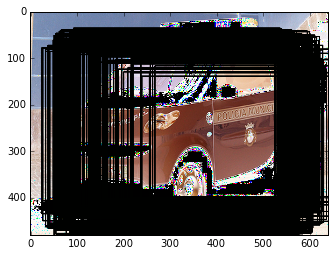

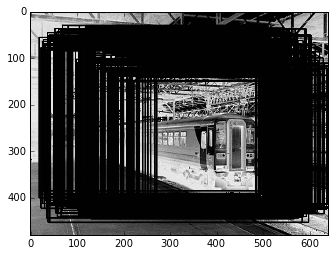

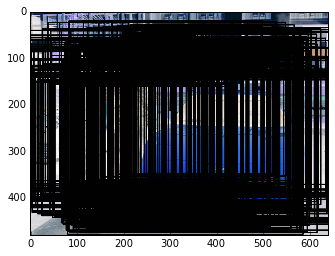

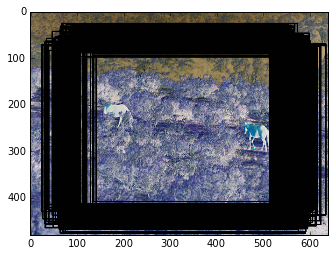

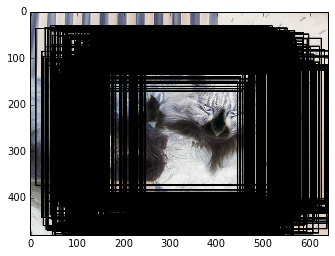

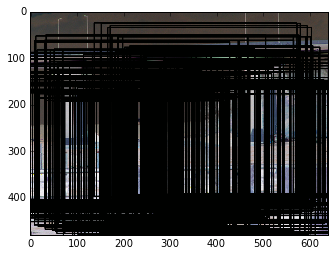

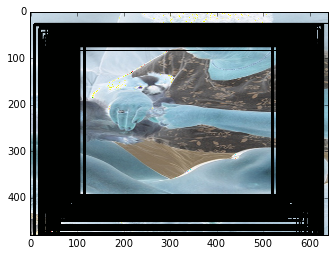

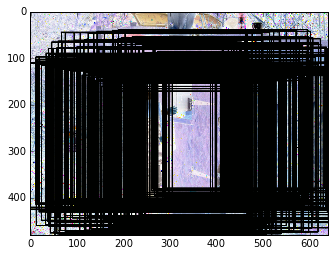

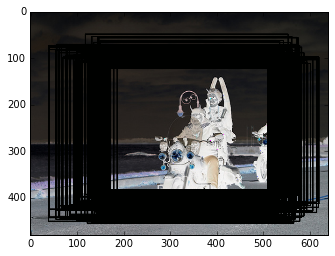

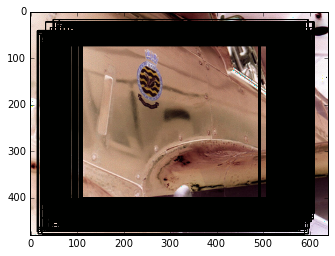

In [25]:
do_pred = True
for _ in range(10):
    lr_feed = {learning_rate: .1}
    if do_pred:
        image, boxes, confidences = sess.run([test_image, test_pred_boxes, test_pred_confidences], feed_dict=lr_feed)
    else:
        image, boxes, confidences = sess.run([test_image, test_true_boxes, test_true_confidences], feed_dict=lr_feed)
    # This probably overlays the rectange on the image???
    test_output_to_log = train_utils.add_rectangles(image,
                                                    confidences,
                                                    boxes,
                                                    H["arch"])[0]
    #print(boxes)
    plt.figure()
    plt.imshow(test_output_to_log)


In [ ]:
len(boxes)

In [ ]:
boxes.shape

In [ ]:
confidences.shape

In [ ]:
np_test_image.shape